In [1]:
%%capture

from cycler import cycler
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
from palettable.cartocolors.sequential import agSunset_7_r
from palettable.cartocolors.qualitative import Bold_7
import pandas
import scipy.stats
import textwrap
from IPython.display import display, HTML

from data.process import combined, map_filter_na_inplace
from data.process import DISLIKE_DTYPE

CMAP_SEQUENTIAL = agSunset_7_r.mpl_colormap
CMAP_QUALITATIVE = Bold_7.mpl_colormap

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.size'] = 12
plt.rcParams['font.weight'] = 'medium'
plt.rcParams['font.sans-serif'] = 'Roboto'
plt.rcParams['axes.edgecolor'] = 'none'
plt.rcParams['axes.grid'] = True
plt.rcParams['axes.axisbelow'] = True
plt.rcParams['axes.labelweight'] = 'medium'
plt.rcParams['figure.titleweight'] = 'medium'
plt.rcParams['figure.titlesize'] = 14
plt.rcParams['grid.color'] = 'lightgrey'

df = combined()
df['source'] = df.form.apply(
    lambda cell: 'Online' if cell == 'English Online' else 'In Person',
).astype('category')
df.isp.cat.remove_unused_categories(inplace=True)
df.isp_tech.cat.remove_unused_categories(inplace=True)


def annotate_percentages(ax, max):
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_width() / max)
        x = p.get_x() + p.get_width()
        y = p.get_y() + p.get_height()/2+0.05
        ax.annotate(
            percentage, (x, y),
            fontweight='semibold',
            bbox=dict(boxstyle='round4', fc='w'),
        )

# Report on Community Engagement

_We represent Municipal Broadband PDX, an advocacy campaign supporting digital equity in the Portland metropolitan area. We are not affiliated with CTC Technology and Energy. We have been working with Multnomah County, Portland, Gresham, Troutdale, Fairview, and Wood Village since 2018 to improve internet access for all._

## Background

In December 2019, we convened two town halls to better understand the needs of communities in Portland's inner east side and eastern Multnomah County as we consider making large investments in our digital future. Each town hall had this format:

1. An educational segment with presentations and status updates from Multnomah County and our campaign
2. A Q&A segment led by Bob Leek, Chief Information Officer, Multnomah County
3. A written survey we asked each individual present to fill out
4. A round-table discussion facilitated by an organizer from our campaign

We held one town hall in Inner Northeast Portland and the other in Gresham. They were approximately two weeks apart. We also asked our Twitter followers who were unable to attend one of our physical town halls to complete the same survey.

_Raw survey response data, as well our methodology for producing the information in this report, is available in our [GitHub repository](https://github.com/municipalbroadband/reports). The surveys include additional qualitative data not analyzed in this report. We always welcome any feedback or further insights._

## Survey findings

We received a total of 168 survey responses, of which we excluded 6 from our analysis because their data were unusable (for example, some people answered no questions or contradicted themselves). We set out to have a rough understanding of the following:

* For our communities, do more tangible access problems, like price and customer service, outweigh abstract societal problems like lack of net neutrality?
* How do people feel about funding and governing a municipal ISP?

### Demographics


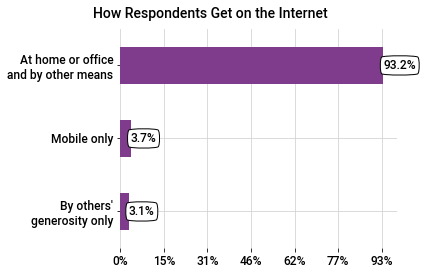

In [2]:
ax = df.filter(['has_internet_premise', 'has_internet_mobile_only', 'has_internet_ext_only']).agg('sum').rename({
    'has_internet_premise': textwrap.fill('At home or office and by other means', 20),
    'has_internet_mobile_only': 'Mobile only',
    'has_internet_ext_only': textwrap.fill("By others' generosity only", 20),
}).plot(
    kind='barh',
    cmap=CMAP_QUALITATIVE,
)
ax.xaxis.set_major_formatter(mtick.PercentFormatter(decimals=0, xmax=len(df.index)))
ax.invert_yaxis()
annotate_percentages(ax, len(df.index))

plt.suptitle('How Respondents Get on the Internet')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

Most of our respondents access the internet from home and/or work.

People frequently ask our campaign if wired internet access in urban areas is an outdated model to pursue given the proliferation of relatively inexpensive mobile data plans. We have yet to see evidence this is the case. In this survey, we asked respondents if they **only** access the internet using mobile data. Very few respondents do so.

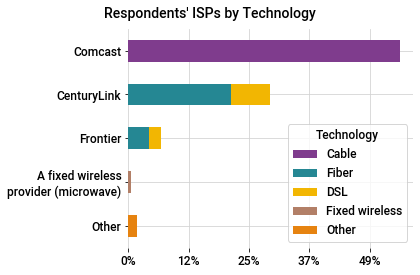

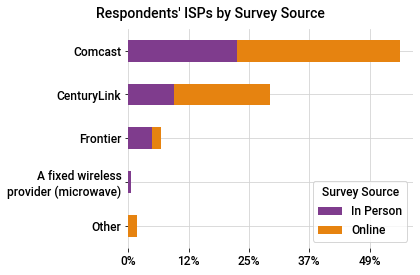

In [3]:
for col, label in {'isp_tech': 'Technology', 'source': 'Survey Source'}.items():
    isps = df.pivot_table(
        index='isp',
        columns=col,
        aggfunc='size',
    ).rename(index=lambda label: textwrap.fill(label, 20))

    ax = isps.plot(kind='barh', stacked=True, cmap=CMAP_QUALITATIVE)
    ax.xaxis.set_major_formatter(mtick.PercentFormatter(decimals=0, xmax=df.has_internet_premise.count()))
    ax.legend(fancybox=True, title=label)
    ax.set_ylabel(None)
    ax.invert_yaxis()

    plt.suptitle("Respondents' ISPs by {0}".format(label))
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    plt.show()

Comcast is the most commonly used ISP among our respondents. Note the regional duopoly between Comcast and the local phone company (either CenturyLink or Frontier, depending on location). Very few respondents use a fixed wireless provider like Stephouse Networks or any other ISP. Looking more closely at the survey data by source, we also surmise that our online survey did not reach many people outside of Portland in eastern Multnomah County where Frontier is available.

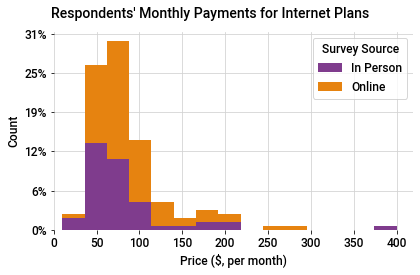

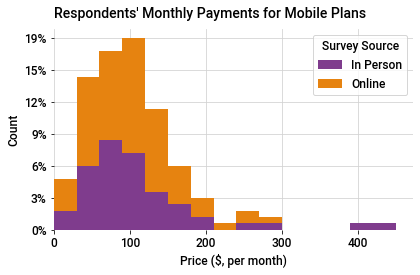

In [4]:
for col, label in {'internet_price': 'Internet', 'mobile_price': 'Mobile'}.items():
    df_pivot = df.filter(['source', col]).pivot(columns='source')
    df_pivot.columns = df_pivot.columns.droplevel()

    ax = df_pivot.plot(kind='hist', stacked=True, bins=15, cmap=CMAP_QUALITATIVE)
    ax.legend(fancybox=True, title='Survey Source')
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(decimals=0, xmax=len(df.index)))

    plt.suptitle("Respondents' Monthly Payments for {0} Plans".format(label))
    plt.xlabel('Price ($, per month)')
    plt.ylabel('Count')
    plt.xlim(left=0)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    plt.show()

Broadly speaking, our online survey respondents paid more than in-person respondents for both internet and mobile plans. As noted above, this may be because our online survey biased to higher-income areas. We also guess that our online audience is more technical than the broader swath of community members who attended our town halls; online respondents may have the means and work requirements or personal reasons to select more expensive plans.

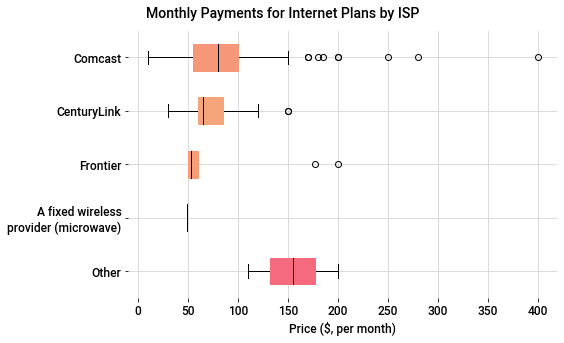

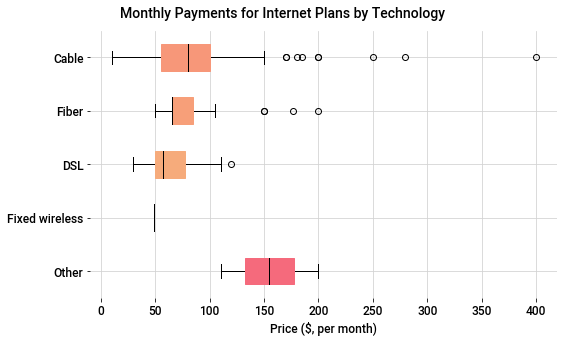

In [5]:
rcmap = cm.ScalarMappable(
    norm=colors.Normalize(vmin=0, vmax=df['internet_price'].max(), clip=True),
    cmap=CMAP_SEQUENTIAL,
)

for group, label in {'isp': 'ISP', 'isp_tech': 'Technology'}.items():
    r = df.boxplot(
        by=df[group].map(lambda label: textwrap.fill(label, 20)),
        column='internet_price',
        vert=False,
        return_type='both',
        patch_artist=True,
        figsize=(8, 5),
    )

    # Color fixes
    mean = df.groupby(group).mean()['internet_price']
    for patch, color in zip(r.internet_price.lines['boxes'], rcmap.to_rgba(mean)):
        patch.set_edgecolor(color)
        patch.set_facecolor(color)

    for k in ['medians', 'whiskers']:
        for line in r.internet_price.lines[k]:
            line.set_color('black')

    r.internet_price.ax.invert_yaxis()

    plt.title(None)
    plt.suptitle('Monthly Payments for Internet Plans by {0}'.format(label))
    plt.xlabel('Price ($, per month)')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    plt.show()

Remember that more than 50% of our respondents use Comcast. These charts give us a clue about price sensitivity. Comparable fiber connectivity through CenturyLink or Frontier is cheaper on average than Comcast, yet we don't see people switching away from Comcast readily. That said, Comcast's higher-speed cable offerings are available in more geographical areas than fiber, which may partially explain why they have so many subscribers.

### Municipal broadband in society

The second part of our survey provides a qualitative look at how people feel about accessing the internet.

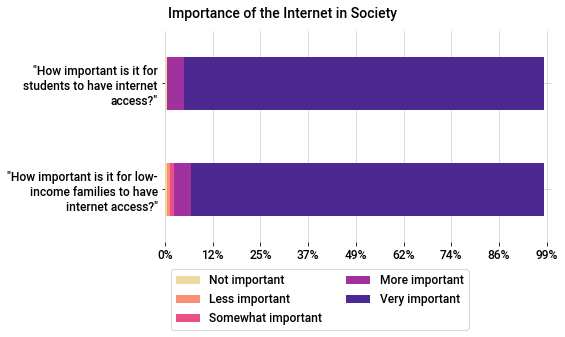

In [6]:
s = df.filter(['importance_student', 'importance_low_income']).stack()
idf = pandas.DataFrame(s.groupby([pandas.Grouper(level=1), s]).size()).unstack()
idf.columns = idf.columns.droplevel()
idf.rename(index={
    'importance_student': textwrap.fill('"How important is it for students to have internet access?"', 30),
    'importance_low_income': textwrap.fill('"How important is it for low-income families to have internet access?"', 30),
}, inplace=True)

ax = idf.plot(kind='barh', stacked=True, cmap=CMAP_SEQUENTIAL, figsize=(8, 5))
ax.xaxis.set_major_formatter(mtick.PercentFormatter(decimals=0, xmax=len(df.index)))

plt.suptitle("Importance of the Internet in Society")
plt.xlim(0, len(df.index))
plt.legend(loc='upper left', bbox_to_anchor=(0, -0.1), ncol=2)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

Without any consideration for price or how the service would be delivered, almost everyone agreed that it is important for both students and low-income families to have internet access.

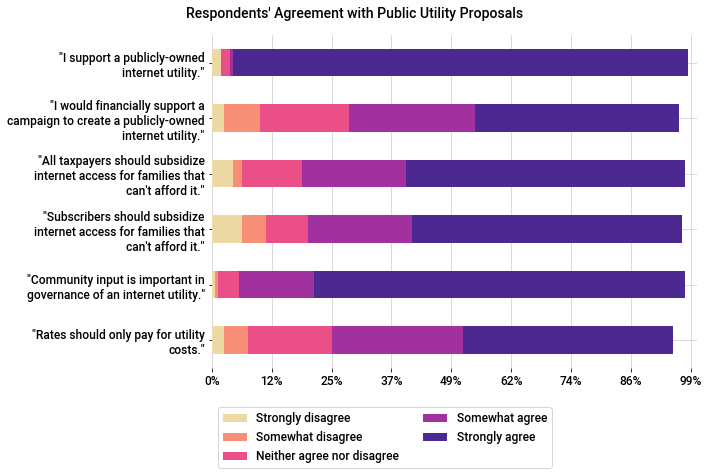

In [7]:
s = df.filter([
    'support_utility',
    'support_financial',
    'importance_user_input',
    'importance_rates_direct',
    'subsidize_subscribers',
    'subsidize_taxpayers',
]).stack()
idf = pandas.DataFrame(s.groupby([pandas.Grouper(level=1), s]).size()).unstack()
idf.columns = idf.columns.droplevel()
idf.rename(index={
    'support_utility': textwrap.fill('"I support a publicly-owned internet utility."', 35),
    'support_financial': textwrap.fill('"I would financially support a campaign to create a publicly-owned internet utility."', 35),
    'subsidize_taxpayers': textwrap.fill('"All taxpayers should subsidize internet access for families that can\'t afford it."', 35),
    'subsidize_subscribers': textwrap.fill('"Subscribers should subsidize internet access for families that can\'t afford it."', 35),
    'importance_user_input': textwrap.fill('"Community input is important in governance of an internet utility."', 35),
    'importance_rates_direct': textwrap.fill('"Rates should only pay for utility costs."', 35),
}, inplace=True)

ax = idf.plot(
    kind='barh',
    stacked=True,
    figsize=(10, 7),
    cmap=CMAP_SEQUENTIAL,
)
ax.xaxis.set_major_formatter(mtick.PercentFormatter(decimals=0, xmax=len(df.index)))

plt.suptitle("Respondents' Agreement with Public Utility Proposals")
plt.xlim(0, len(df.index))
plt.legend(loc='upper left', bbox_to_anchor=(0, -0.1), ncol=2)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

We asked a series of questions about funding and oversight of a municipal ISP. We established a baseline by asking each individual whether they supported such an ISP. Unsurprisingly, our respondents almost universally strongly agreed in their support of municipal broadband. Then we wanted to understand:

1. **How do we subsidize access for those unable to afford internet access?** We thought there might be a preference for subscribers to the ISP subsidizing access instead of offloading the burden to all taxpayers, but did not find that to be the case. Over 75% of respondents agreed that all taxpayers should subsidize internet access as needed. Some respondents were in fact more emphatic about this, indicating disagreement for subscriber-paid subsidies only.
2. **Should a municipal ISP be able to use its funding for initiatives other than operating the network?** We wondered whether people would accommodate a municipal ISP spending some of its income on, for example, community education or access to new technology in schools, so we asked whether rates should only pay for utility costs. Although we again found about 75% of respondents in agreement with the premise, this question proved more controversial with only about 50% of people strongly agreeing.
3. **Do subscribers want to help run their ISP?** An overwhelming number of respondents, around 90%, agreed that community input is an important aspect of the governance of any internet utility. With Federal Communications Commission (FCC) rulings about net neutrality and National Security Agency (NSA) surveillance making news cycles relatively frequently over the past few years, it isn't surprising to see a desire for more transparency and direct democracy in a government-run ISP.

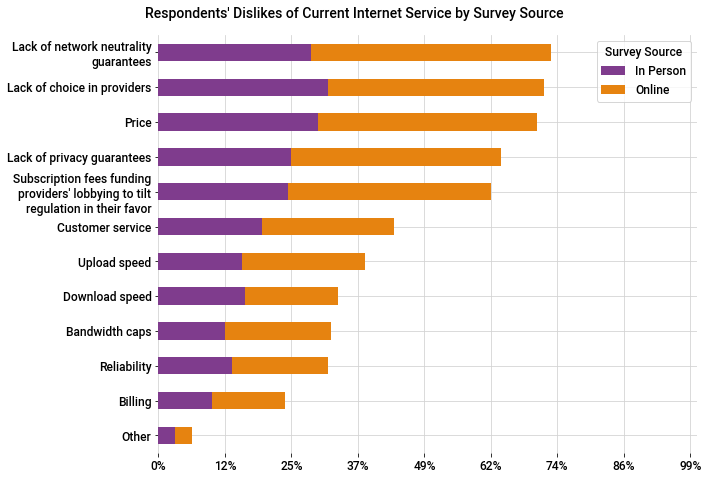

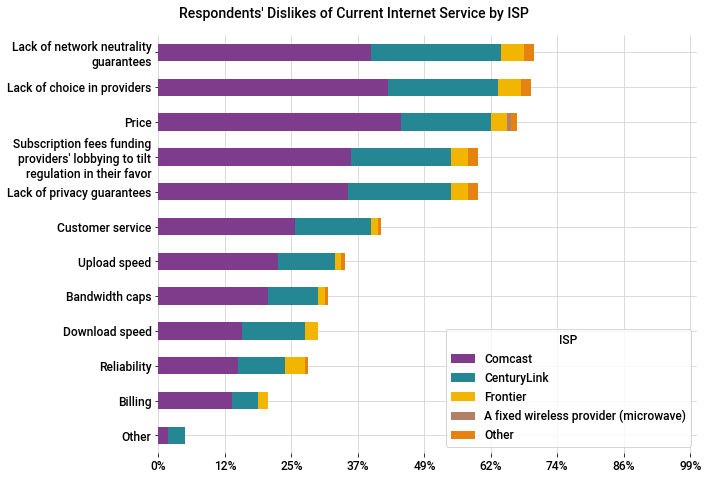

In [8]:
ddf = df.filter(['source', 'isp', 'dislikes']).explode('dislikes')
map_filter_na_inplace(
    lambda s: s.apply(lambda cell: textwrap.fill(cell, 30)),
    ddf, 'dislikes',
)

for group, label in {'source': 'Survey Source', 'isp': 'ISP'}.items():
    s = ddf.groupby([group, 'dislikes']).size()
    ddf_pivot = pandas.DataFrame(s).unstack(level=0)
    ddf_pivot.columns = ddf_pivot.columns.droplevel().astype(str)

    sum_sort = ddf_pivot.sum(axis=1).sort_values().index

    ax = ddf_pivot.loc[sum_sort].plot(
        kind='barh',
        stacked=True,
        figsize=(10, 7),
        cmap=CMAP_QUALITATIVE,
    )
    ax.legend(fancybox=True, title=label)
    ax.xaxis.set_major_formatter(mtick.PercentFormatter(decimals=0, xmax=len(df.index)))

    plt.suptitle("Respondents' Dislikes of Current Internet Service by {0}".format(label))
    plt.xlim(0, len(df.index))
    plt.ylabel(None)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    plt.show()

To get a better sense of our communities' needs for internet access, we asked respondents to enumerate their dislikes of their current service, allowing them to select many answers. We anticipated more practical dislikes (price, reliability, speed, etc.) because these problems prevent people from effectively using the internet on a day-to-day basis. Of those, only price made it into the top tier of responses. Instead, respondents indicated that societal issues like lack of net neutrality guarantees, lack of choice in providers, and lack of privacy guarantees were problematic for them.

Notably, for Comcast customers, price was indeed the most common dislike, outweighing the top two choices for our respondents as a whole.

In [9]:
ddf = df.filter(['internet_price', 'dislikes']).dropna(how='any')
ddf = ddf[lambda df: ((df.internet_price - df.internet_price.mean()) / df.internet_price.std(ddof=0)) < 3]

def dislikes_regression(df, cat):
    dislikes_cat = ddf.dislikes.apply(lambda s: 1 if cat in s else 0)
    regression = scipy.stats.linregress(ddf.internet_price, dislikes_cat)
    return (regression.slope, regression.rvalue ** 2)

display(HTML(pandas.DataFrame({
    cat: dislikes_regression(ddf, cat) for cat in DISLIKE_DTYPE.categories.drop(['Other'])
}).T.rename(columns={0: 'Slope', 1: 'r²'}).to_html()))


,Slope,r²
Price,0.002804,0.055002
Reliability,-0.000443,0.001311
Customer service,0.000906,0.004686
Billing,0.000050,0.000020
Lack of choice in providers,0.001062,0.008826
Download speed,0.000940,0.005697
Upload speed,0.001197,0.008563
Bandwidth caps,0.002319,0.033223
Lack of network neutrality guarantees,0.001467,0.017220
Lack of privacy guarantees,0.001793,0.020261


With that in mind, and considering that Comcast customers pay more on average than our other respondents, we anticipated a positive relationship between household internet service costs and disliking price of service. Our data shows a very loose correlation; furthermore, we did not observe any correlation between internet price and any other dislike.

## Round table discussions

We dedicated the final hour of each town hall to round table discussions facilitated by organizers from the Municipal Broadband PDX campaign. We aimed to have tables of about eight people, including the facilitator, and each facilitator had the same set of topics to focus on. At a high level, these were:

* Concerns about broadband access in our market
* Possible models for municipal broadband (open access, integrated public offering, etc.)
* Price sensitivity
* Phased deployment
* Concerns and ideas for public ownership

In some cases, we deviated from those specific topics because everyone at the table was engaged in a different but relevant conversation. We highlight a few of these discussions as well.

### Concerns about broadband access in our market

For this topic, we aimed to understand what concerns a municipal ISP might need to address that we didn't capture in our survey. Several participants were opposed to the idea of having any price tiering based on income, contending that putting the burden of proof on low-income families in fact prevents them from getting service. Participants also noted that billing transparency (for example, clearly enumerating any fees for equipment rental) is as important as low prices.

### Possible models for municipal broadband

Participants seemed to prefer whichever operating model conferred the most transparency and choice to them. Concerns like pricing, technical support, etc. did not come up frequently in these discussions. For example, one participant wants the county to collect metrics about connection fairness to guarantee net neutrality.

In our second town hall, Bob Leek, Multnomah County's CIO, indicated the potential for a partnership with Comcast to provide (as an example) Telehealth services, calling it a "win-win-win." Virtually all participants in the subsequent discussion expressed at least some concern with this idea, worrying about a slippery slope to broader incumbent control or whether money that would otherwise stay within our communities would be diverted to out-of-state corporations. Participants indicated they would likely only tolerate public-private partnerships if the network is truly open access.

### Price sensitivity

In concert with our survey findings, our qualitative discussion about price sensitivity revealed a sincere willingness to pay more for internet access that aligned with participants' technical needs or ethics. Specifically, people wanted higher upload speeds and a renewed focus on content creation, expressed a lack of trust in incumbent providers to keep prices low (even if they initially undercut a municipal offering), and indicated a desire to increase competition between ISPs.

### Phased deployment

Participants mostly agreed that they were comfortable waiting longer for the chance to connect to a municipal network if it reduced the overall risk of the deployment. However, some wanted to see a complete plan first; others were concerned about delays in initial rollouts. We also discussed a potential opportunity to require new construction to fund fiber connectivity, offsetting deployment costs in underserved communities.

Participants agreed that the county should prioritize a deployment strategy that targets areas of highest need as quickly as possible.

### Concerns and ideas for public ownership

Participants' concerns about public ownership aligned with their preferences for the operating model, worrying mainly about lack of transparency in network operations. Although we briefly addressed topics like illegal spying, participants agreed that private for-profit ISPs were as likely, if not more likely, to be engaged in those activities.

Participants were in favor of contracting out the physical work to build the network, and saw a boon to the local economy by opting to use union labor for construction.

### Paying for deployment

Several participants wanted to discuss how to pay for the network, so we spent some time discussing different types of bonds, how local improvement districts work, and how other communities have paid for their publicly-owned infrastructure. Generally, people felt impatient about what we interpret as the general approach municipal governments use to fund projects. This led to a variety of creative suggestions emphasizing a rapid start to construction. One individual proposed a novel idea: to perform studies of building foundations in the course of laying underground fiber and to sell those studies to insurance companies. Feasibility of this particular idea aside, we do wonder if there exist secondary markets, tangential to fiber deployment or network operations, that the county could readily take advantage of.

## Municipal broadband and COVID-19

Since our town halls took place, society has changed dramatically with the onset of the COVID-19 pandemic. For the first time in history, we are forced to understand the internet's role in everyone's lives, and we see the disproportionate negative impact on those who don't have internet access. School systems nationwide scrambled to get their students connected for virtual classes while those applying for unemployment without internet access waited in hours-long phone queues.

> Now, more than ever, the need for access to quality high speed internet access is clearly evident. As we continue to move through a world in lock-down due to a health crisis the only way most of us can survive, connect, work, and learn is hinged upon an available connection to the internet. This crisis has only amplified the well known divide between the connected (haves) and the disconnected (have nots). Our students, impoverished families, homeless, and so many others are left behind without this access in a digital world. It is past time for a solution that can be flexible and robust enough to meet the needs of an ever changing landscape. It is clear that a municipal broadband offering is the only solution that will serve the needs of our community, to provide connectivity as a utility as we do with water, electricity, and plumbing. We need this resource in the greater Portland area as a means to grow, learn, and serve all of the people who live and work here!

-- Don Wolff, Chief Technology Officer, Portland Public Schools

## Conclusion

At a high level, this report provides an informal yet informative glimpse at the way the people in Multnomah County want to use the internet. As we've come to expect from our communities, we care about far more than a low price and a reliable connection (although those are important too!).

First, we know we need an operating model that focuses on transparency, democracy, and equity. Net neutrality and privacy need to be core tenets of the network, and they need to be auditable. The network must have an organizational structure that allows for community governance; we don't want to see it buried under layers of middle management in the Department of County Assets. And we _must_ prioritize access for those who need it most, treating internet access as a human right.

Second, we find that if our municipal network takes care of our societal needs, those who are able to afford internet access will happily pay a higher rate for service than what existing ISPs offer. Like the renewed focus on environmentalism has shown us in the realm of physical products, when ethics are on the line, prices are not necessarily a race to the bottom.

Finally, we want to emphasize the opportunities our residents and businesses see in municipal broadband. The energized and enthusiastic atmosphere of our town halls made it so incredibly evident that the participants understand how attractive municipal broadband networks are. They see the potential for business investment. They see the benefit to workers in keeping money in our local economy and using union labor. They know the long-term impact on society when every child has access to the vast educational material available on the internet. And they've demonstrated that they're willing to work with us, and with their government, to come up with creative solutions to make municipal broadband a reality.

We'd like to thank our wonderful communities for participating in our events and for their support as we try to build an amazing digital future for everyone. We look forward to continuing to work with Multnomah County on this project!

_This report is provided as an addendum to the Multnomah County Municipal Broadband Feasibility Study on June 9, 2020, by [Noah Fontes](mailto:noah@municipalbroadbandpdx.org), Founding Organizer, Municipal Broadband PDX, with many thanks to the Municipal Broadband PDX team._